## Comparison of Ackermann, Yamartino, and Verral-Williams methods for calculating the standard deviation of wind azimuth using the given data sets.



## Getting the data

In [196]:
from bs4 import BeautifulSoup
#import requests library
import requests
import pandas as pd
import numpy as np
import math
import urllib.request

In [197]:
# Define the URL template with placeholders for start and end dates
url_template = 'https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=VOCI&data=drct&data=sknt&year1={start_year}&month1={start_month}&day1={start_day}&year2={end_year}&month2={end_month}&day2={end_day}&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=3&report_type=4'

# Define the start and end dates as variables
start_year = 2023
start_month = 3
start_day = 1
end_year = 2023
end_month = 3
end_day = 31

# Substitute the variables into the URL template to get the full URL
url = url_template.format(start_year=start_year, start_month=start_month, start_day=start_day, end_year=end_year, end_month=end_month, end_day=end_day)

In [198]:
r = requests.get(url)
r.content
soup = BeautifulSoup(r.content, 'html5lib') # If this line causes an error, run 'pip install html5lib' or install html5lib
body_tag=soup.find('body')
body_contents = body_tag.string.strip()
rows = body_contents.split('\n')
data = [row.split(',') for row in rows]
df = pd.DataFrame(data[1:], columns=data[0])

In [199]:
df['valid'] = pd.to_datetime(df['valid'])
df['drct'] = df['drct'].replace('M',np.nan)
df['sknt'] = df['sknt'].replace(0.,np.nan)
df['drct'] = df['drct'].replace('0.00',np.nan)
df['drct'] = pd.to_numeric(df['drct'])
df['sknt'] = pd.to_numeric(df['sknt'])
df['sknt'] = df['sknt']*(0.514) #Converting to degree

## Acherman

### Formulas used

$$U = n^{-1}\sum u_{i} \quad \text{mean of u}$$  
$$V = n^{-1}\sum v_{i} \quad \text{mean of v}$$ 
$$\sigma_{u}^{2} = n^{-1}\sum u_{i}^{2}-U^{2}\quad \text{variance of u}$$
$$\sigma_{v}^{2} = n^{-1}\sum v_{i}^{2}-V^{2}\quad \text{variance of v}$$
$$\sigma_{uv} = n^{-1}\sum u_{i}v_{i}-UV \quad \text{covariance of u and v}$$
$$S=\left(U^2+V^2\right)^{1 / 2}, \quad \text{vector mean wind speed}$$
$$\sigma_d=\left[V^2 \sigma_u{ }^2+U^2 \sigma_v{ }^2-2 U V \sigma_{u v}\right]^{1 / 2} S^{-2}$$

In [200]:
def sin_row(row):
    return -row['sknt'] * np.sin(np.radians(row['drct']))

def cos_row(row):
    return -row['sknt'] * np.cos(np.radians(row['drct']))

In [201]:
def acherman(df):
    df = df.dropna()
    U = df['u'].mean()
    V = df['v'].mean()
    u_var = df['u'].var()
    v_var = df['v'].var()
    cov = df['u'].cov(df['v']) 
    
    S = (((U**2)+(V**2)))**(1/2)
    num = ((V**2)*(u_var)) + ((U**2)*(v_var)) - (2*(U*V)*cov)
    result = (num**(1/2))*(S**(-2))
    return result

In [202]:
df["u"] = df.apply(sin_row, axis=1)
df["v"] = df.apply(cos_row, axis=1)

In [203]:
df

,station,valid,drct,sknt,u,v
0,VOCI,2023-03-01 00:00:00,NaN,0.000,NaN,NaN
1,VOCI,2023-03-01 00:30:00,NaN,0.000,NaN,NaN
2,VOCI,2023-03-01 01:00:00,NaN,0.000,NaN,NaN
3,VOCI,2023-03-01 01:30:00,70.0,1.028,-0.966004,-3.515967e-01
4,VOCI,2023-03-01 02:00:00,90.0,1.028,-1.028000,-6.294685e-17
...,...,...,...,...,...,...
1421,VOCI,2023-03-30 21:30:00,NaN,0.000,NaN,NaN
1422,VOCI,2023-03-30 22:00:00,NaN,0.000,NaN,NaN
1423,VOCI,2023-03-30 22:30:00,80.0,1.028,-1.012382,-1.785103e-01
1424,VOCI,2023-03-30 23:00:00,80.0,1.028,-1.012382,-1.785103e-01


The standard deviations of wind directions is computed in an interval of 3 hours

3 hours will have 6 datapoints and if at least 4 of them dont have a null value, we evaluate the standard deviation at that point

In [204]:
acherman_ans = pd.DataFrame()
data = []
for i in range(0,len(df),6):
    fd = df[i:i+6]
    fd = fd.dropna()
    if len(fd) >= 4 and i!=690: #i!=690 has been added as there was one outlier which was skewing the graph
        data.append([df.iloc[i]['valid'],math.degrees(acherman(fd))])
acherman_ans = pd.DataFrame(data, columns=['Time', 'std'])

In [205]:
def date(row):
    return row['Time'].date()

acherman_ans["Date"] = acherman_ans.apply(date, axis=1)

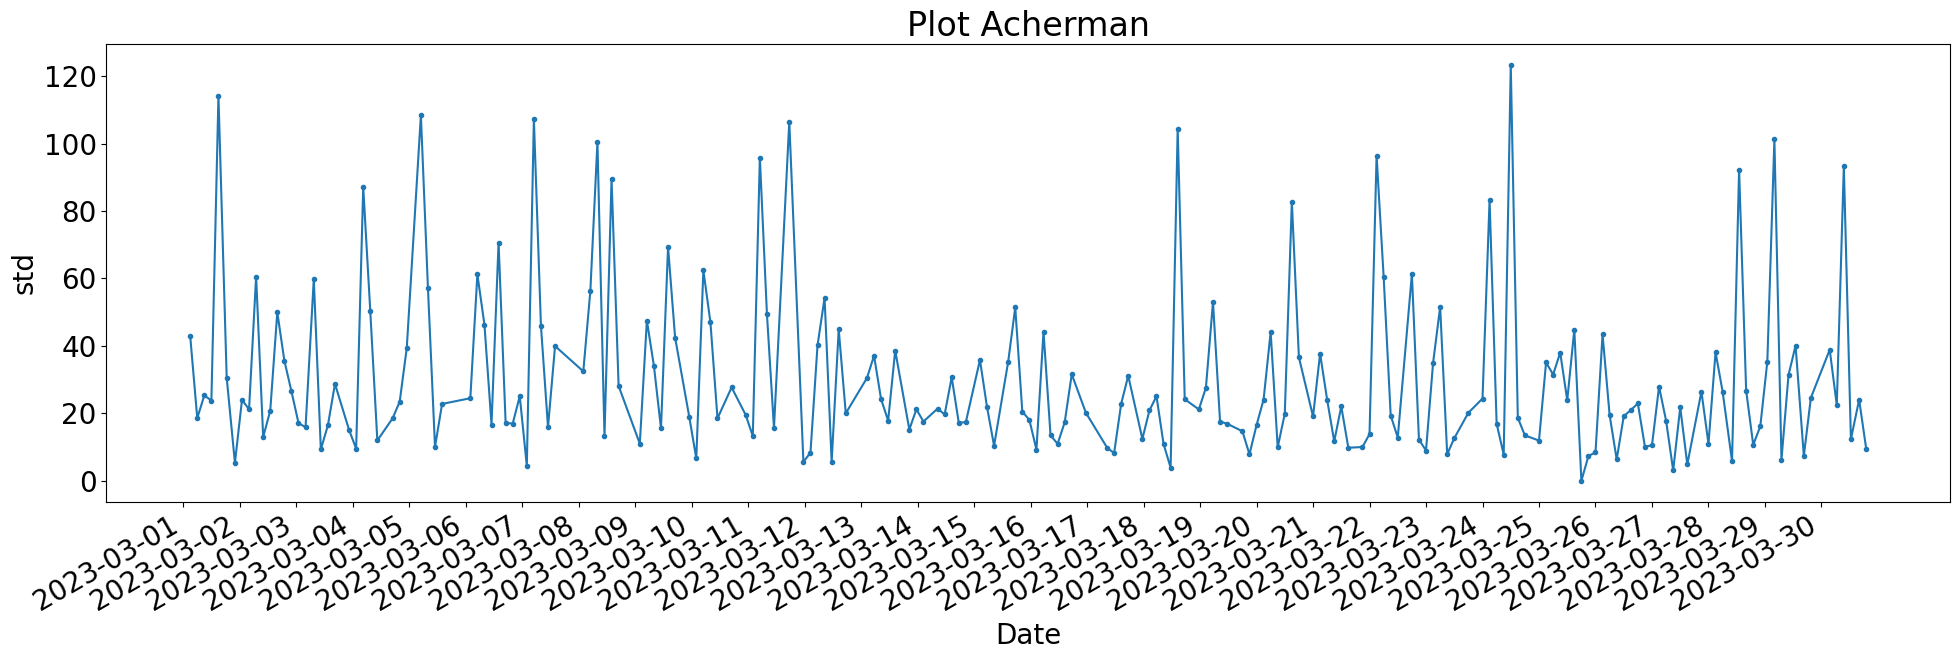

In [206]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from matplotlib import dates as mpl_dates

plt.rcParams["figure.figsize"] = [20.0, 7]
plt.rcParams["figure.autolayout"] = True

plt.plot_date(acherman_ans["Time"], acherman_ans["std"], linestyle = "solid", fmt=".")
 
#date_format = mpl_dates.DateFormatter('%')
plt.title('Plot Acherman')


plt.xticks(acherman_ans['Date'].unique(),rotation=30, ha='right')
plt.gcf().autofmt_xdate()
#plt.gca().xaxis.set_major_formatter(date_format)

plt.xlabel('Date')
plt.ylabel('std')

plt.show()
#plt.savefig("test.jpg")

## Yamartino


$$s_{a}=\frac{1}{n}\sum_{i=1}^n \sin{\theta _i}$$
$$c_a=\frac{1}{n}\sum_{i=1}^n \cos{\theta _i}$$

Then the average wind direction is given via the four-quadrant arctan(x,y) function as

$$\theta_{a} = \arctan(c_{a},s_{a})$$

From twenty different functions for $\sigma_\theta$ using variables obtained in a single-pass of the wind direction data, Yamartino found the best function to be

$$\sigma_\theta  = \arcsin(\epsilon)[1+(\frac{2}{\sqrt3}-1)\varepsilon ^3]$$

where 

$$\varepsilon=\sqrt{1-(s_a^2+c_a^2)}$$

    

In [207]:
from math import sqrt, asin

def yamartino(df):
    ss = df['sin'].sum()
    sc = df['cos'].sum()
    an = len(df)
    as_ = ss / an
    ac_ = sc / an
    e = sqrt(1.0 - (as_ ** 2 + ac_ ** 2))
    sigth = asin(e) * (1.0 + 0.1547 * e ** 3.0)
    return sigth

In [208]:
df['sin'] = np.sin(np.radians(df['drct']))
df['cos'] = np.cos(np.radians(df['drct']))

In [209]:
yamartino_ans = pd.DataFrame()
data = []
for i in range(0,len(df),6):
    fd = df[i:i+6]
    fd = fd.dropna()
    if len(fd) >= 4:
        data.append([df.iloc[i]['valid'],math.degrees(yamartino(fd))])
yamartino_ans = pd.DataFrame(data, columns=['Time', 'std'])
        # ans['time'] = df.iloc[i]['valid']
        # ans['std'] = math.degrees(acherman(fd))
        #print(df.iloc[i]['valid'], math.degrees(acherman(fd)), i)


In [210]:
yamartino_ans["Date"] = yamartino_ans.apply(date, axis=1)

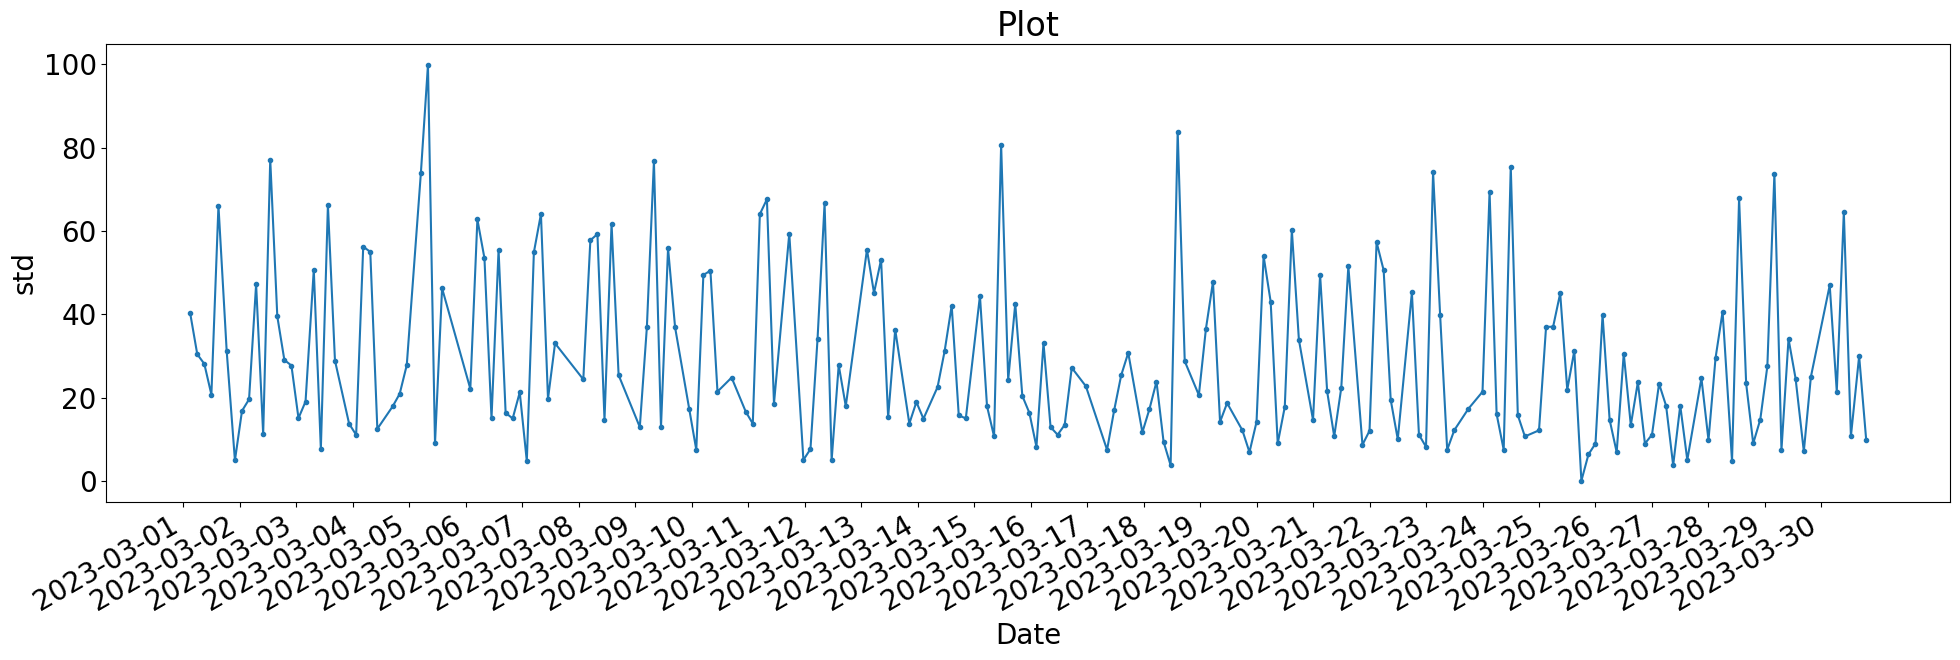

In [211]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from matplotlib import dates as mpl_dates

plt.rcParams["figure.figsize"] = [20.0, 7]
plt.rcParams["figure.autolayout"] = True

plt.plot_date(yamartino_ans["Time"], yamartino_ans["std"], linestyle = "solid", fmt=".")
 
#date_format = mpl_dates.DateFormatter('%')
plt.title('Plot')


plt.xticks(yamartino_ans['Date'].unique(),rotation=30, ha='right')
plt.gcf().autofmt_xdate()
#plt.gca().xaxis.set_major_formatter(date_format)

plt.xlabel('Date')
plt.ylabel('std')

plt.show()
#plt.savefig("test.jpg")

## Veral williams

$$m_{\left(\cos \theta_i\right)}  =\left(\sum \cos \theta_i\right) / N$$
$$m_{\left(\sin \theta_i\right)}  =\left(\sum \sin \theta_i\right) / N, $$

$$s_{\left(\cos \theta_i\right)}  =\left[\frac{\sum \cos ^2 \theta_i-\left(\sum \cos \theta_i\right)^2 / N}{(N-1)}\right]^{1 / 2} $$
$$s_{\left(\sin \theta_i\right)}  =\left[\frac{\sum \sin ^2 \theta_i-\left(\sum \sin \theta_i\right)^2 / N}{(N-1)}\right]^{1 / 2} $$


Then the two vectors $v_{1}$ and $v_{2}$ will be calculated as follows
$$
v_{1}=\begin{bmatrix}
m_{\left(\sin \theta_i\right)}-s_{\left(\sin \theta_i\right)}\\m_{\left(\cos \theta_i\right)}+s_{\left(\cos \theta_i\right)}
\end{bmatrix}
$$
$$
v_{2}=\begin{bmatrix}
m_{\left(\sin \theta_i\right)}+s_{\left(\sin \theta_i\right)}\\m_{\left(\cos \theta_i\right)}-s_{\left(\cos \theta_i\right)}
\end{bmatrix}
$$

In formulating the estimator, the hypothesis was made that the directions of $\mathbf{v}_1$ and $\mathbf{v}_2$ would correspond to one standard deviation $\sigma_{\theta}$, either side of the mean direction $\mu_\theta$. Accordingly, an estimate of $\sigma_\theta$ would be obtained as half the angle between the vectors, i.e.,
$$
\hat{\sigma}_\theta=0.5 \cos ^{-1}\left(\frac{\mathbf{v}_1 \cdot \mathbf{v}_2}{\left|\mathbf{v}_1\right| \cdot\left|\mathbf{v}_2\right|}\right),
$$
where $\mathbf{v}_1 \cdot \mathbf{v}_2$ is the inner product of the vectors and $\left|\mathbf{v}_1\right|$ and $\left|\mathbf{v}_2\right|$ are the absolute magnitudes of the vectors. 

In [212]:
import math

def verwil(df):
    an = len(df)
    ss = df['sin'].sum()
    sc = df['cos'].sum()
    sss = (df['sin'] ** 2).sum()
    scc = (df['cos'] ** 2).sum()
    as_ = ss / an
    c = ss * ss / an
    sigs = math.sqrt((sss - c) / an)
    ac = sc / an
    d = sc * sc / an
    sigc = math.sqrt((scc - d) / an)
    as_ = abs(as_)
    ac = abs(ac)
    vos = as_ - sigs
    voc = ac + sigc
    vts = as_ + sigs
    vtc = ac - sigc
    dot = vos * vts + voc * vtc
    ao = math.sqrt(vos * vos + voc * voc)
    at = math.sqrt(vts * vts + vtc * vtc)
    siga = 0.5 * math.acos(dot / (ao * at))
    return siga


In [213]:
verwil_ans = pd.DataFrame()
data = []
for i in range(0,len(df),6):
    fd = df[i:i+6]
    fd = fd.dropna()
    if (len(fd) >= 4) and i!=690:
        data.append([df.iloc[i]['valid'],math.degrees(verwil(fd))])
verwil_ans = pd.DataFrame(data, columns=['Time', 'std'])

In [214]:
verwil_ans["Date"] = verwil_ans.apply(date, axis=1)

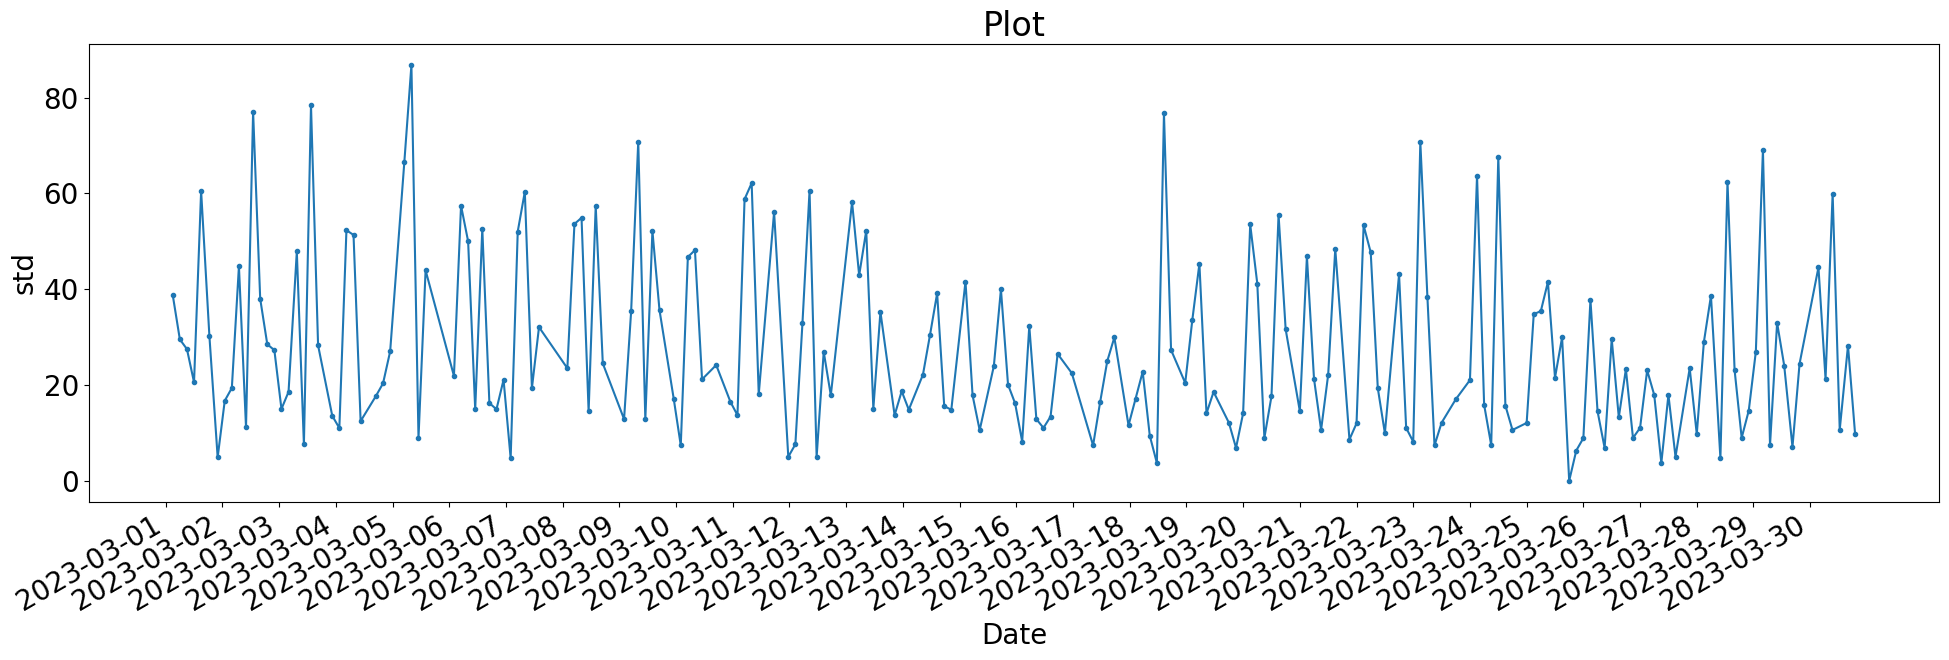

In [215]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from matplotlib import dates as mpl_dates

plt.rcParams["figure.figsize"] = [20.0, 7]
plt.rcParams["figure.autolayout"] = True

plt.plot_date(verwil_ans["Time"], verwil_ans["std"], linestyle = "solid", fmt=".")
 
#date_format = mpl_dates.DateFormatter('%')
plt.title('Plot')


plt.xticks(verwil_ans['Date'].unique(),rotation=30, ha='right')
plt.gcf().autofmt_xdate()
#plt.gca().xaxis.set_major_formatter(date_format)

plt.xlabel('Date')
plt.ylabel('std')

plt.show()
#plt.savefig("test.jpg")

## Combined

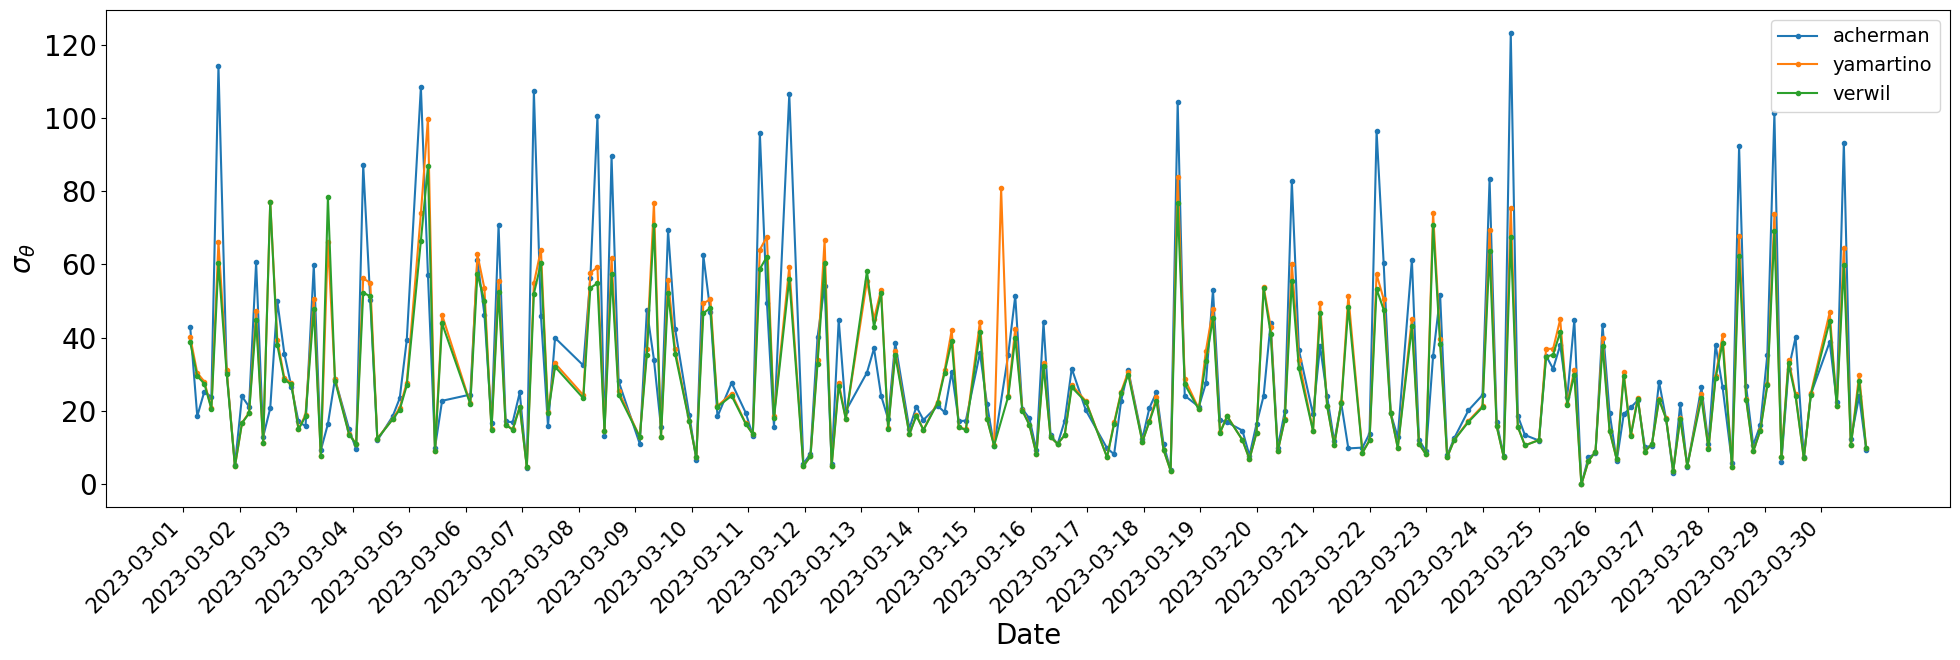

In [216]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from matplotlib import dates as mpl_dates
import matplotlib


plt.rcParams["figure.figsize"] = [20.0, 7]
plt.rcParams["figure.autolayout"] = True
matplotlib.rcParams.update({'font.size': 20})
plt.plot_date(acherman_ans["Time"], acherman_ans["std"], linestyle = "solid", fmt=".",label="acherman")
plt.plot_date(yamartino_ans["Time"], yamartino_ans["std"], linestyle = "solid", fmt=".",label="yamartino")
plt.plot_date(verwil_ans["Time"], verwil_ans["std"], linestyle = "solid", fmt=".",label="verwil")
#date_format = mpl_dates.DateFormatter('%H')
#plt.title('Plot')


plt.xticks(acherman_ans['Date'].unique(),rotation=45, ha='right',fontsize=15)
#plt.gcf().autofmt_xdate()
#plt.gca().xaxis.set_major_formatter(date_format)

plt.xlabel('Date')
plt.ylabel("$\sigma_{\\theta}$")
plt.legend(fontsize=14)
plt.show()
#plt.savefig("combined.jpg")

## Reference

Means and Standard Deviations of Horizontal Wind Components
G. R. Ackermann

A Comparison of Several "Single-Pass" Estimators of the Standard Deviation
of Wind Direction R. J. YAMARTINO

Comparison of Three Methods for Calculating the Standard Deviation of the
Wind Direction D. BRUCE TURNER

A Method for Estimating the Standard Deviation of Wind Directions
K. A. VERRALL AND R. L. WILLIAMS